In [ ]:
# 파일이름 : LAB_data_generator.ipynb
# 코드설명 : 고무 배합비와 연구소 검사 데이터에 대한 전처리 및 모델 학습 데이터 세트 생성
# 입/출력 : 배합정보, LAB 검사결과, 원재료코드분류 / LAB 데이터 세트(7개)
# 유의 사항 : -
# 최종수정 : 2023년 11월 20일
# 제 작 자 : 홍민성 (mshong@micube.co.kr), 맹영준 (myj6223@micube.co.kr)
# Copyright : MICUBE Solution, Inc.

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import seaborn as sns
sns.set(rc={'figure.figsize':(15, 5)})
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

## 1. 데이터 로드 및 개별 데이터 이상치 수정, 결합

### 1) 데이터 로드

In [2]:
lab_recipe_df=pd.read_csv('./dataset/sfitapp_recipe_lab.csv')           # 배합비 데이터
lab_insp_df=pd.read_csv('./dataset/insp_lab_val_df_remove.csv')         # 검사 데이터
lar_cd_df=pd.read_excel('./dataset/jrcode_230907_fin.xlsx')             # 원재료 코드 및 분류표

### 2) 각 데이터 상의 이상치 수정 (레오, 무늬, PHR, 비중)

#### 레오 및 무늬 데이터 이상치 수정

In [3]:
# 레오 데이터 초 값으로 변경
cols = ['insp_rheo_ts2_val','insp_rheo_t90_val']
for col in cols:
    lab_insp_df[col] = pd.to_datetime(lab_insp_df[col], format='%M:%S', errors='coerce')
    lab_insp_df[col] = lab_insp_df[col].dt.minute*60 + lab_insp_df[col].dt.second
    
# 무늬 검사 시간 조정
lab_insp_df['insp_mny_148_val'] = np.where((lab_insp_df['insp_mny_148_val']=='1+4'), 5, lab_insp_df['insp_mny_148_val'])
lab_insp_df['insp_mny_148_val'].value_counts()

5    584
Name: insp_mny_148_val, dtype: int64

#### 비중이 평균 1.2에 비해 너무 큰(135,119) 경우 제거
- 1500PA017_T003,1600PA030_T005

In [5]:
lab_insp_df=lab_insp_df[~(lab_insp_df['Combined_rm'].isin(['1500PA017_T003','1600PA030_T005']))]
lab_insp_df.shape

(6819, 63)

#### PHR 관련 데이터 제거
- 공통원재료 코드를 기반으로 뒤 2개의 문자열이 C를 포함하는 경우, 해당 문자열로 대치. 이외에는 공통원재료 코드 그대로 사용	
- 6가지 nan값은 제거, 제거된 데이터와 같은 항목의 데이터가 존재하여 분석에 문제 없음	
    - 160-4P-H001 T001, 160-4P-H001 T002, 160-4P-H001 T003, 160-4P-L001 T001, 160-4P-L001 T002, 160-4P-L001 T003

In [4]:
lab_recipe_df['lar_tmp_cd']=lab_recipe_df['com_lar_cd'].str[-2:]

lab_recipe_df['lar_cd']=np.where((lab_recipe_df['lar_cd'].isna())&(lab_recipe_df['lar_tmp_cd'].str.contains('C')),lab_recipe_df['lar_tmp_cd'],
                      np.where((lab_recipe_df['lar_cd'].isna()),lab_recipe_df['com_lar_cd'],lab_recipe_df['lar_cd']))

display(lab_recipe_df[(lab_recipe_df['lar_cd'].isna())])

lab_recipe_df=lab_recipe_df[~(lab_recipe_df['lar_cd'].isna())]
lab_recipe_df.shape

,lab_cd,test_no,srt_sqn,asgm_yn,com_lar_cd,com_lar_nm,lar_cd,lar_nm,hs_vl,sg_vl,...,mix_ds_cd,fct_cd,vol_vl,phr_sum,inpt_wgt_sum,hs_vl_sum,sg_vl_sum,rgs_dttm,upd_dttm,lar_tmp_cd
31919,160-4P-H001,T001,11,N,NaN,NaN,NaN,NaN,NaN,NaN,...,-F1,T-4-05,0,128.0,0,0,36.571,2017-04-13 09:38:14,2017-05-10 17:06:35,NaN
31932,160-4P-H001,T002,11,N,NaN,NaN,NaN,NaN,NaN,NaN,...,-F1,T-4-05,0,0.0,0,0,0.000,2017-04-17 11:52:29,2017-04-19 01:24:15,NaN
31945,160-4P-H001,T003,11,N,NaN,NaN,NaN,NaN,NaN,NaN,...,-F1,T-4-05,76,132.0,"2,931",0,37.714,2017-04-19 13:32:18,2017-04-20 14:40:32,NaN
32057,160-4P-L001,T001,11,N,NaN,NaN,NaN,NaN,NaN,NaN,...,-F1,T-4-05,76,0.0,0,0,0.000,2017-04-27 10:49:37,2017-04-27 22:25:16,NaN
32070,160-4P-L001,T002,11,N,NaN,NaN,NaN,NaN,NaN,NaN,...,-F1,T-4-05,76,0.0,0,0,0.000,2017-05-03 09:51:24,2017-05-03 15:30:33,NaN
32083,160-4P-L001,T003,11,N,NaN,NaN,NaN,NaN,NaN,NaN,...,-F1,T-4-05,76,0.0,0,0,0.000,2017-05-08 11:12:35,2017-05-08 23:19:36,NaN


(105250, 22)

### 3) 배합비와 검사 데이터, 원자재코드표 결합

In [6]:
# 기본 정보
recipe_cols=['lab_pk','mix_ds_cd','srt_sqn','lar_cd','phr']

# 기본물성 관련 검사 조건
insp_pps_cols=['lab_pk','insp_pps_temp1_val','insp_pps_mnt1_val',
           'insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

# 가류/점도 관련 검사 조건
insp_curing_cols = ['insp_rheo_ts2_val','insp_rheo_t90_val','insp_rheo_min_val','insp_rheo_max_val','insp_mny_min_val',
                    'insp_mny_temp_val','insp_mny_148_val','insp_rheo_temp_val','insp_rheo_mnt_val']

# 최종 원자재별 결합 데이터 포멧
fin_cols = ['lab_pk','mix_ds_cd','srt_sqn','lar_cd','중분류','소분류','phr','insp_pps_temp1_val','insp_pps_mnt1_val',
          'insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val',
          'insp_rheo_ts2_val','insp_rheo_t90_val','insp_rheo_min_val','insp_rheo_max_val','insp_mny_min_val',
          'insp_mny_temp_val','insp_mny_148_val','insp_rheo_temp_val','insp_rheo_mnt_val']

In [7]:
# lab_pk 생성 및 데이터 결합
lab_recipe_df['lab_pk']=lab_recipe_df['lab_cd'].str.replace('-','')+'_'+lab_recipe_df['test_no'].str.replace('-','')
lab_insp_df['lab_pk']=lab_insp_df['Combined_rm']
display(f"검사 데이터의 lab_pk 수: {lab_insp_df['lab_pk'].nunique():,}, 레시피 데이터의 lab_pk 수: {lab_recipe_df['lab_pk'].nunique():,}")
display(f"교차: {len(set(lab_insp_df['lab_pk'].unique().tolist()).intersection(set(lab_recipe_df['lab_pk'].unique().tolist()))):,}")

# 레시피와 검사 데이터 결합
lab_df=pd.merge(lab_recipe_df[recipe_cols],lab_insp_df[insp_pps_cols + insp_curing_cols],how='inner',on='lab_pk')
lab_df['CODE']=lab_df['lar_cd'].replace('-','').str[:2]

remain_lab_df=lab_df[lab_df['CODE'].str.match('C[1-9]')]
remain_lab_df.drop(columns=['CODE'],inplace=True)
remain_lab_df['중분류']=np.nan
remain_lab_df['소분류']=np.nan
remain_lab_df=remain_lab_df[fin_cols]

# 원자재의 중/소분류 추가
lar_cd_df['CODE'] = lar_cd_df['First CODE'] + lar_cd_df['Second CODE']
fin_lab_df=pd.merge(lab_df, lar_cd_df[['CODE','중분류','소분류']], how='inner', on='CODE')
fin_lab_df=fin_lab_df[fin_cols]
fin_lab_df=pd.concat([fin_lab_df,remain_lab_df],axis=0)
fin_lab_df=fin_lab_df.sort_values(by=['lab_pk','srt_sqn'])
fin_lab_df.reset_index(drop=True,inplace=True)
print(fin_lab_df.shape)
fin_lab_df.info()

'검사 데이터의 lab_pk 수: 6,819, 레시피 데이터의 lab_pk 수: 6,754'

'교차: 6,750'

(105168, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105168 entries, 0 to 105167
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   lab_pk              105168 non-null  object 
 1   mix_ds_cd           105168 non-null  object 
 2   srt_sqn             105168 non-null  int64  
 3   lar_cd              105168 non-null  object 
 4   중분류                 98454 non-null   object 
 5   소분류                 98454 non-null   object 
 6   phr                 105168 non-null  object 
 7   insp_pps_temp1_val  97343 non-null   float64
 8   insp_pps_mnt1_val   97130 non-null   float64
 9   insp_pps_hs_val     66433 non-null   float64
 10  insp_pps_sg_val     66541 non-null   float64
 11  insp_pps_ts_val     65635 non-null   float64
 12  insp_pps_eb_val     65792 non-null   float64
 13  insp_rheo_ts2_val   67694 non-null   float64
 14  insp_rheo_t90_val   68028 non-null   float64
 15  insp_rheo_min_val   6

## 2. 결합 데이터 이상치 수정 및 분포 시각화 검토

### 1) 데이터 타입 변경

#### mix_ds_cd : string
- 앞에 '-' 문자 제거

In [8]:
col='mix_ds_cd'
fin_lab_df[col]=fin_lab_df[col].astype('string')
fin_lab_df[col]=fin_lab_df[col].str.replace('-','') # -문자 제거
fin_lab_df[col].value_counts(),fin_lab_df[col].value_counts(normalize=True)

(C1    69865
 F1    34870
 *F      418
 C2       15
 Name: mix_ds_cd, dtype: Int64,
 C1    0.664318
 F1    0.331565
 *F    0.003975
 C2    0.000143
 Name: mix_ds_cd, dtype: Float64)

#### lab_pk, lar_cd, 중분류, 소분류 :  string

In [ ]:
col='lab_pk'
fin_lab_df[col]=fin_lab_df[col].astype('string')
col='lar_cd'
fin_lab_df[col]=fin_lab_df[col].astype('string')
col='중분류'
fin_lab_df[col]=fin_lab_df[col].astype('string')
col='소분류'
fin_lab_df[col]=fin_lab_df[col].astype('string')
col='mix_ds_cd'
fin_lab_df[col]=fin_lab_df[col].astype('string')

### 2) PHR 데이터 상대적 조정
- 최대 100으로 조정
- Fn과 Cn에 따른 데이터 필터링 등

#### phr : float64, 값의 범위 체크해야함. [2분정도 소요]
- phr 이 일반적으로 100을 넘기지 않는데 (100이하 97.3%), 넘는 부분들이 발생
- 황다혜 수석님과 논의 후, 100을 넘기는 lab_cd와 test_no 리스트를 화인테크에 검토받기로 하여 자료 넘김
    - 1-1) 각 검사별(lab_cd/test_no)로 최대 phr이 100이 아닌 경우	
        - mix_ds_cd == Cn인 경우, (value/최대값*100)으로 변환 후 사용
        - mix_ds_cd == *F은 Fn보다 우선됨, *F과 Cn 데이터들을 포함하여 (value/최대값*100)으로 변환 후 사용
        - mix_ds_cd == Fn인 경우, Cn 데이터들을 포함하여 (value/최대값*100)으로 변환 후 사용
	
    - 1-2) 각 검사별(lab_cd/test_no)로 최대 phr이 100인 경우, 그대로 사용	

In [9]:
# 데이터 체크
fin_lab_df['phr']=fin_lab_df['phr'].astype(str).str.replace(',','').astype(float)
fin_lab_df['phr'].dtype

# 최대 phr가 100이 아닌 lab_pk 리스트 생성
tmp_df=fin_lab_df.groupby(['lab_pk'])['phr'].max().reset_index()
nonePHR100_ls=tmp_df[tmp_df['phr']!=100]['lab_pk'].unique().tolist()
print(len(nonePHR100_ls))

# 구분하여 생성
PHR100_lab_tmp=fin_lab_df[~(fin_lab_df['lab_pk'].isin(nonePHR100_ls))]
nonePHR100_lab_tmp=fin_lab_df[(fin_lab_df['lab_pk'].isin(nonePHR100_ls))]
print('ori:',len(fin_lab_df),'sum:',len(PHR100_lab_tmp)+len(nonePHR100_lab_tmp))

# none PHR 100 조정
nonePHR100_lab_fin=pd.DataFrame()
for nonePHR100_pk in tqdm(nonePHR100_ls):
    tmp_df=nonePHR100_lab_tmp[nonePHR100_lab_tmp['lab_pk']==nonePHR100_pk]
    maxPhr=tmp_df['phr'].max()
    
    cn_ls=tmp_df[tmp_df['mix_ds_cd'].str.contains('C')]['mix_ds_cd'].unique().tolist()
    f_ls=tmp_df[tmp_df['mix_ds_cd'].str.contains('F')]['mix_ds_cd'].unique().tolist()
    
    for cn_val in cn_ls:
        tmp_cn_df=tmp_df[tmp_df['mix_ds_cd']==cn_val]
        maxPhr=tmp_cn_df['phr'].max()
        tmp_cn_df['phr']=tmp_cn_df['phr']/maxPhr*100
        nonePHR100_lab_fin=pd.concat([nonePHR100_lab_fin,tmp_cn_df],axis=0)
    
    if len(f_ls)!=0:
        if '*F' in f_ls:
            tmp_f_df=tmp_df[tmp_df['mix_ds_cd']!='F1']
            maxPhr=tmp_f_df['phr'].max()
            tmp_f_df['phr']=tmp_f_df['phr']/maxPhr*100
            tmp_f_df['mix_ds_cd']='*F'
            nonePHR100_lab_fin=pd.concat([nonePHR100_lab_fin,tmp_f_df],axis=0)
        else:
            tmp_f_df=tmp_df[tmp_df['mix_ds_cd']!='*F']
            maxPhr=tmp_f_df['phr'].max()
            tmp_f_df['phr']=tmp_f_df['phr']/maxPhr*100
            tmp_f_df['mix_ds_cd']='F1'
            nonePHR100_lab_fin=pd.concat([nonePHR100_lab_fin,tmp_f_df],axis=0)
print('PHR(!=100) 조정 완료!')

# 결합
fin_lab_df=pd.concat([PHR100_lab_tmp,nonePHR100_lab_fin],axis=0)
print('phr>100인 row #: ',len(fin_lab_df[fin_lab_df['phr']>100]))
fin_lab_df[fin_lab_df['phr']>100]
fin_lab_df.reset_index(drop=True, inplace=True)

6726
ori: 105168 sum: 105168


100%|██████████| 6726/6726 [02:39<00:00, 42.09it/s] 

PHR(!=100) 조정 완료!
phr>100인 row #:  0


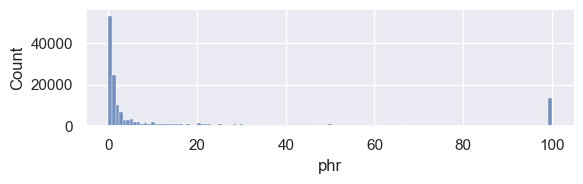

In [10]:
# phr 분포 시각화
sns.displot(fin_lab_df['phr'], height=2, aspect=3)

### 3) 변수별 분포 시각화 및 이상치 점검

#### 기본물성과 무늬, 레오에 대한 검사 온도의 분포 시각화, float64

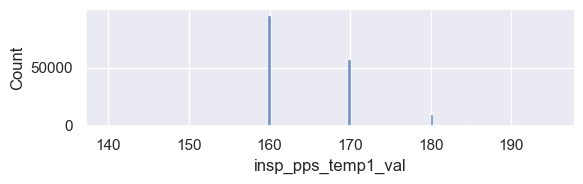

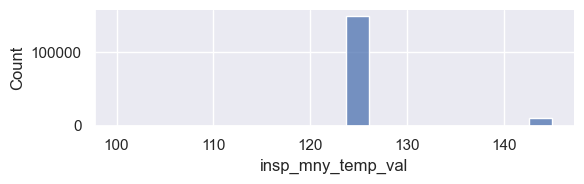

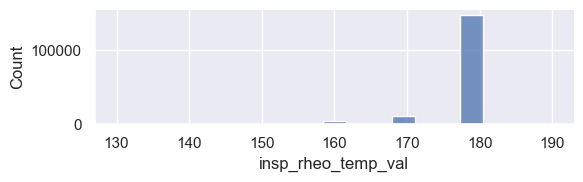

In [ ]:
# 기본물성과 무늬, 레오에 대한 검사 온도의 분포 시각화
temp_cols = ['insp_pps_temp1_val','insp_mny_temp_val','insp_rheo_temp_val']

for col in temp_cols:
    fin_lab_df[col]=fin_lab_df[col].astype('float64')
    # display(fin_lab_df[col].dtype)
    sns.displot(fin_lab_df[col], height=2, aspect=3)

#### 기본물성과 무늬, 레오에 대한 검사 시간의 분포 시각화, float64

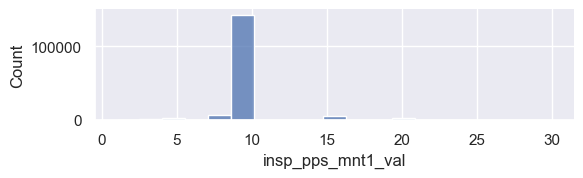

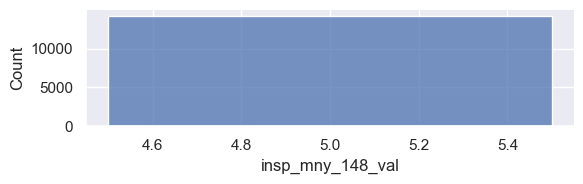

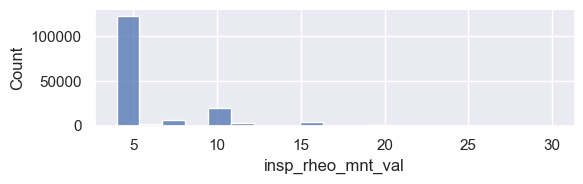

In [13]:
# 기본물성과 무늬, 레오에 대한 검사 시간의 분포 시각화
time_cols = ['insp_pps_mnt1_val','insp_mny_148_val','insp_rheo_mnt_val']
for col in time_cols:

    fin_lab_df[col]=fin_lab_df[col].astype('float64')
    # display(fin_lab_df[col].dtype)
    # display(fin_lab_df[col].describe())
    sns.displot(fin_lab_df[col], height=2, aspect=3)  

#### insp_pps_hs_val 경도, float64

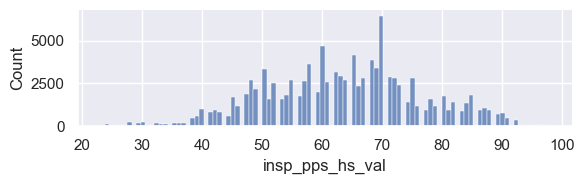

In [14]:
# 경도 분포 시각화 분석
col='insp_pps_hs_val'
fin_lab_df[col]=fin_lab_df[col].astype('float64')
# print(fin_lab_df[col].dtype)
sns.displot(fin_lab_df[col], height=2, aspect=3)
# fin_lab_df[col].describe()

#### insp_pps_sg_val 비중 < 10, float64

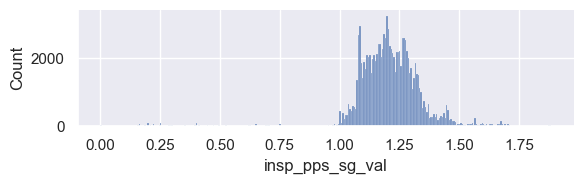

In [15]:
# 비중 분포 시각화 분석
col='insp_pps_sg_val'
fin_lab_df[col]=fin_lab_df[col].astype('float64')
# print(fin_lab_df[col].dtype)
sns.displot(fin_lab_df[fin_lab_df[col]<10][col], height=2, aspect=3)
# fin_lab_df[col].describe()

#### insp_pps_ts_val 인장 분포 시각화 분석, float64

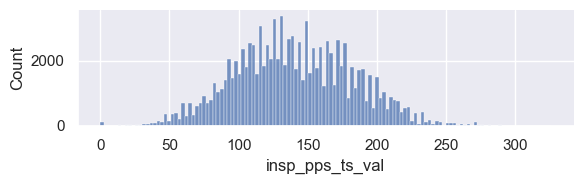

In [16]:
# 인장 분포 시각화 분석
col='insp_pps_ts_val'
fin_lab_df[col]=fin_lab_df[col].astype('float64')
# print(fin_lab_df[col].dtype)
sns.displot(fin_lab_df[col], height=2, aspect=3)
# fin_lab_df[col].describe()

#### insp_rheo_ts2_val 레오 시각 데이터 분석, float64

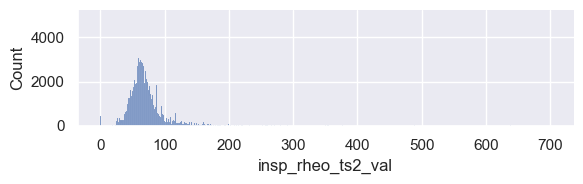

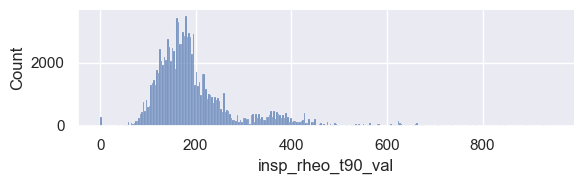

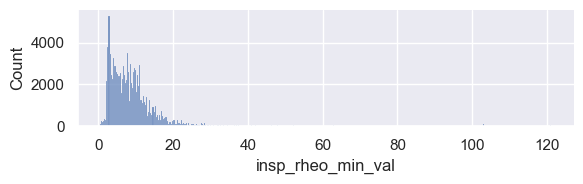

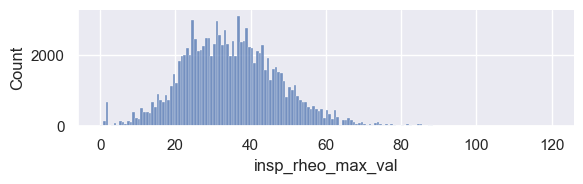

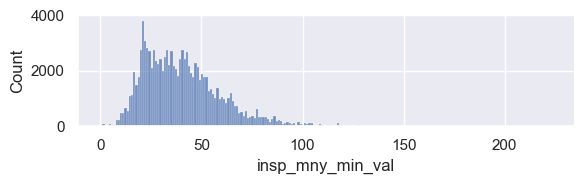

In [17]:
# 5가지 레오값 시각 데이터 분석
for col in ['insp_rheo_ts2_val', 'insp_rheo_t90_val', 'insp_rheo_min_val', 'insp_rheo_max_val', 'insp_mny_min_val']:
    # display(fin_lab_df[col].value_counts())

    fin_lab_df[col]=fin_lab_df[col].astype('float64')
    # display(fin_lab_df[col].dtype)
    sns.displot(fin_lab_df[col], height=2, aspect=3)
    # display(fin_lab_df[col].describe())

## 3. 최종 LAB 데이터 세트 저장
- 물성값 : 기본물성(4개), 가류/점도(3개)

In [18]:
# 임시 데이터 저장
fin_lab_df.to_csv('./tmp_dataset/total_lab_data.csv', index=False)

### 원재료별 최종 LAB 데이터 세트 생성 및 저장

In [19]:
x_cols=['lab_pk','mix_ds_cd','lar_cd','중분류','소분류','srt_sqn','phr']
# 기본물성
pps_y_cols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']
# 가류도
curing_y_cols = ['insp_rheo_ts2_val', 'insp_rheo_t90_val', 'insp_rheo_min_val', 'insp_rheo_max_val', 'insp_mny_min_val']      

yCols = pps_y_cols + curing_y_cols
for yCol in yCols:
    if yCol in pps_y_cols:
        insp_condi_cols = ['insp_pps_temp1_val','insp_pps_mnt1_val']
    else:
        if 'mny' in yCol:
            insp_condi_cols= ['insp_mny_temp_val','insp_mny_148_val']
        else:
            insp_condi_cols= ['insp_rheo_temp_val','insp_rheo_mnt_val']
    
    tmp_fin_df=fin_lab_df[x_cols+insp_condi_cols+[yCol]].dropna()
    tmp_fin_df.columns = ['lab_pk','mix_ds_cd','JRCODE','중분류','소분류','srt_sqn','PHR','INSP_TEMP','INSP_TIME', yCol]
    if len(tmp_fin_df) == 0:
        continue
    
    group_df = fin_lab_df.groupby(['lab_pk','mix_ds_cd'])['srt_sqn'].max().reset_index()
    lower_limit = group_df['srt_sqn'].mean() - group_df['srt_sqn'].std()*2
    upper_limit = group_df['srt_sqn'].mean() + group_df['srt_sqn'].std()*2
    tmp_df = group_df[(group_df['srt_sqn'].between(lower_limit, upper_limit))]

    fin_df = pd.merge(tmp_fin_df, tmp_df[['lab_pk','mix_ds_cd']], how='inner', on=['lab_pk','mix_ds_cd'])
    fin_df.to_csv(f'./tmp_dataset/lab_regr_data_{yCol}_fin_noZero.csv', index=False)

### 고무배합별 최종 LAB 데이터 세트 생성 및 저장

In [20]:
yCols = ['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val','insp_rheo_min_val','insp_rheo_max_val','insp_mny_min_val']

for yCol in yCols:
    print(yCol)

    # 데이터 로드
    df = pd.read_csv(f'./tmp_dataset/lab_regr_data_{yCol}_fin_noZero.csv')
    # df['JRCODE'] = df['lar_cd']
    # df['PHR'] = df['phr']

    # 반복 대상 컬럼명
    columns_to_reshape = ['JRCODE','PHR']

    reshaped_rows = []

    # 단일값이어야 하는 것들은 그대로 그룹화
    grouped = df.groupby(['lab_pk', 'mix_ds_cd', 'INSP_TEMP', 'INSP_TIME', yCol])

    for (lab_pk, mix_ds_cd, INSP_TEMP, INSP_TIME, yCol_val), group in grouped:
        reshaped_row = {'lab_pk': lab_pk, 'mix_ds_cd': mix_ds_cd, 'INSP_TEMP': INSP_TEMP,
                        'INSP_TIME': INSP_TIME, yCol: yCol_val}  # 새로운 행 초기화
        
        # 'srt_sqn'의 값에 따라 컬럼 이름을 변경하고 값을 저장합니다.
        for col in columns_to_reshape:
            for _, row in group.iterrows():
                srt_sqn_val = int(row['srt_sqn'])
                new_col_name = f"{srt_sqn_val}_{col}"  # 새로운 컬럼 이름 생성
                reshaped_row[new_col_name] = row[col]  # 값 저장

        reshaped_rows.append(reshaped_row)

    # 결과를 데이터프레임으로 변환
    reshaped_df_efficient = pd.DataFrame(reshaped_rows)
    # reshaped_df_efficient.fillna(0, inplace=True)
    reshaped_df_efficient = reshaped_df_efficient[reshaped_df_efficient[yCol]!=0]

    reshaped_df_efficient.to_csv(f'./tmp_dataset/lab_regr_data_{yCol}_fin_noZero.csv', index = False, encoding="utf-8-sig")

# 결과 확인
reshaped_df_efficient.head()

insp_pps_hs_val
insp_pps_sg_val
insp_pps_ts_val
insp_pps_eb_val
insp_rheo_min_val
insp_rheo_max_val
insp_mny_min_val


,lab_pk,mix_ds_cd,INSP_TEMP,INSP_TIME,insp_mny_min_val,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,...,15_PHR,16_PHR,17_PHR,18_PHR,12_JRCODE,12_PHR,19_JRCODE,19_PHR,20_JRCODE,20_PHR
0,105FQA001_T001,C1,125.0,5.0,9.1,EE017A,NN774A,FF001D,FF009A,OP004A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,105FQA001_T001,F1,125.0,5.0,9.1,EE017A,NN774A,FF001D,FF009A,OP004A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1302PA001_T001,C1,125.0,5.0,15.1,EE015C,EE011A,EE015B,CB003A,CB001C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1302PA001_T001,F1,125.0,5.0,15.1,EE015C,EE011A,EE015B,CB003A,CB001C,...,0.13489,0.161063,0.483189,0.100664,NaN,NaN,NaN,NaN,NaN,NaN
4,1302PA001_T002,C1,125.0,5.0,11.8,EE015C,EE011A,CB003A,CB001C,CB011B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
